In [5]:
import numpy as np
import tensorflow as tf
import keras as k
from keras import Sequential
import random
from keras.layers import Embedding
from tensorflow.contrib.tensorboard.plugins import projector
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import h5py
import pickle
import pdb
from progressbar import log_progress

log_dir = '/home/steich/NF_Prize_Data/log'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
x_train = []
y_train = []
with open('../data/user_embedding_5_train.tsv', 'r') as iFile:
    for line in iFile:
        line = line.replace('\n', '')
        line = line.split('\t')
        x_train.append(eval(line[1]))
        y_train.append(int(line[0]))
        
epochs = 100
batch_size = 32
embedding_size = 64
num_sampled = 64

with open('../data/name_one_hot_dict.pickle', 'rb') as handle:
    name_one_hot = pickle.load(handle)
    
name_count = len(name_one_hot)

def generate_batch(train_features, train_labels, batch_size, steps):
    
    batch_samples = np.zeros((batch_size))
    batch_labels = np.zeros((batch_size, 1))
    index_list = list(range(len(train_labels)))
    random.shuffle(index_list)
    batch_count = 0
    step = 0
    
    while step < steps:
        
        curr_index = index_list[-1]
        for i in train_features[curr_index]:
            
            if batch_count == 32:
                batch_count = 0
                step += 1
                yield (batch_samples, batch_labels)
            
            batch_labels[batch_count][0] = name_one_hot[train_labels[curr_index]]
            batch_samples[batch_count] = name_one_hot[i]
            batch_count += 1
            
        index_list.pop()
        
graph = tf.Graph()
with graph.as_default():
    
    #input data here
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        #valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
    with tf.device('/gpu:0'):
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([name_count, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)
            
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [name_count, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)))
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([name_count]))
            
    
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                inputs=embed,
                labels=train_labels,
                num_sampled=num_sampled,
                num_classes=name_count))
        
    tf.summary.scalar('loss', loss)
    
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
        
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    #valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    #similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    merged = tf.summary.merge_all()
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    
with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter(log_dir, session.graph)
    
    init.run()
    print('Initialized')
    
    steps = 1000
    average_loss = 0
    step = 0
    run_metadata = tf.RunMetadata()
    
    for epoch in range(epochs):
        if epoch > 0:
            print('Epoch: ', epoch, ' - Average Loss: ', average_loss / steps)
            average_loss = 0
        else:
            print('Epoch: ', epoch)
            
        for batch_inputs, batch_labels in log_progress(generate_batch(x_train, y_train, batch_size, steps),
                                                      every=1,
                                                      size=steps,
                                                      name="Batch"):
            
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

            run_metadata = tf.RunMetadata()

            _, summary, loss_val = session.run(
                [optimizer, merged, loss],
                feed_dict=feed_dict,
                run_metadata=run_metadata)
            average_loss += loss_val

            writer.add_summary(summary, step)
            step += 1
        
    writer.add_run_metadata(run_metadata, 'step%d' % step)
    final_embeddings = normalized_embeddings.eval()
    saver.save(session, os.path.join(log_dir, 'metadata.ckpt'))
    
writer.close()

from sklearn.manifold import TSNE
    
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
n = len(final_embeddings)
sample = random.sample(range(n), 500)
low_dim_embs = tsne.fit_transform([final_embeddings[i] for i in sample])
labels = sample
plt.figure(figsize=(18,18))
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x,y)
    plt.annotate(label,
                    xy=(x, y),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
plt.savefig("/home/steich/NF_Prize_Data/data/tsne_user_embeddings_bow_all.png")
plt.show()
    
with open('/home/steich/NF_Prize_Data/data/user_emb_bow_all_unweighted.tsv', 'w') as f:
    for i, embs in enumerate(final_embeddings):
        emb_str = [str(emb) for emb in embs]
        f.write(str(i) + '\t' + '\t'.join(emb_str) + '\n')

Initialized
Epoch:  0


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  1  - Average Loss:  283.5191455078125


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  2  - Average Loss:  246.00300521850585


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  3  - Average Loss:  227.03899909973146


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  4  - Average Loss:  218.4958323059082


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  5  - Average Loss:  207.8366540222168


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  6  - Average Loss:  203.00528020477296


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  7  - Average Loss:  196.81856108093262


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  8  - Average Loss:  191.62682769012451


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  9  - Average Loss:  186.65267475128175


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  10  - Average Loss:  180.86068506622314


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  11  - Average Loss:  176.29879320526123


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  12  - Average Loss:  174.3675444793701


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  13  - Average Loss:  170.4111496810913


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  14  - Average Loss:  168.44341356658936


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  15  - Average Loss:  163.22703876495362


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  16  - Average Loss:  161.99055155944825


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  17  - Average Loss:  156.7311489944458


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  18  - Average Loss:  156.00185328674317


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  19  - Average Loss:  153.62825244140626


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  20  - Average Loss:  151.9342024230957


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  21  - Average Loss:  148.25106731414795


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  22  - Average Loss:  148.3395797958374


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  23  - Average Loss:  145.58033193588255


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  24  - Average Loss:  143.8072889251709


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  25  - Average Loss:  141.48424085998536


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  26  - Average Loss:  137.96877207946778


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  27  - Average Loss:  134.3753046646118


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  28  - Average Loss:  134.68260595321655


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  29  - Average Loss:  132.5386593170166


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  30  - Average Loss:  131.37853480148314


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  31  - Average Loss:  128.4825033569336


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  32  - Average Loss:  128.150484664917


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  33  - Average Loss:  127.65446790695191


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  34  - Average Loss:  124.05337464523315


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  35  - Average Loss:  123.16943781661988


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  36  - Average Loss:  119.84592724227905


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  37  - Average Loss:  118.5213285369873


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  38  - Average Loss:  114.09631381988525


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  39  - Average Loss:  112.94472573471069


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  40  - Average Loss:  112.05984980392456


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  41  - Average Loss:  108.66903461837768


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  42  - Average Loss:  107.67557219314575


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  43  - Average Loss:  104.68890421676636


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  44  - Average Loss:  102.56912061309815


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  45  - Average Loss:  100.90123011779785


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  46  - Average Loss:  100.47323007774354


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  47  - Average Loss:  96.9183102607727


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  48  - Average Loss:  95.0335832862854


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  49  - Average Loss:  92.35064570426941


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  50  - Average Loss:  91.57211373138428


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  51  - Average Loss:  89.38675587177276


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  52  - Average Loss:  86.36626233100891


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  53  - Average Loss:  86.1283260269165


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  54  - Average Loss:  81.78224021339416


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  55  - Average Loss:  81.73335832214356


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  56  - Average Loss:  79.5312299785614


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  57  - Average Loss:  76.43633165168762


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  58  - Average Loss:  76.52626535987854


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  59  - Average Loss:  75.70547509765625


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  60  - Average Loss:  72.24980896949768


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  61  - Average Loss:  70.97621735572815


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  62  - Average Loss:  69.5589343624115


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  63  - Average Loss:  67.81097803497315


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  64  - Average Loss:  66.53924289131164


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  65  - Average Loss:  66.17630471134186


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  66  - Average Loss:  64.62760472774505


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  67  - Average Loss:  62.919974111557


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  68  - Average Loss:  60.719752239704135


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  69  - Average Loss:  59.090929181575774


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  70  - Average Loss:  57.465622061729434


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  71  - Average Loss:  56.96054111385345


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  72  - Average Loss:  55.39389208173752


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  73  - Average Loss:  54.29842814445496


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  74  - Average Loss:  53.35000224399567


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  75  - Average Loss:  53.2729402756691


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  76  - Average Loss:  51.18016174411774


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  77  - Average Loss:  50.18706592845917


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  78  - Average Loss:  48.73495174694061


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  79  - Average Loss:  47.787412889003754


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  80  - Average Loss:  47.282373956680296


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  81  - Average Loss:  46.387939210414885


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  82  - Average Loss:  44.857550431251525


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  83  - Average Loss:  44.57172016954422


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  84  - Average Loss:  44.33460368251801


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  85  - Average Loss:  42.86710823106766


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  86  - Average Loss:  40.583620801448824


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  87  - Average Loss:  41.38075096559525


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  88  - Average Loss:  41.13366020345688


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  89  - Average Loss:  39.66315418672561


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  90  - Average Loss:  39.37438282346726


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  91  - Average Loss:  37.97528449821472


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  92  - Average Loss:  38.25089786958694


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  93  - Average Loss:  36.80241765487194


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  94  - Average Loss:  36.58650936460495


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  95  - Average Loss:  36.19403285264969


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  96  - Average Loss:  35.6241794090271


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  97  - Average Loss:  35.03462269592285


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  98  - Average Loss:  33.79413080644608


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  99  - Average Loss:  33.35084868097305


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

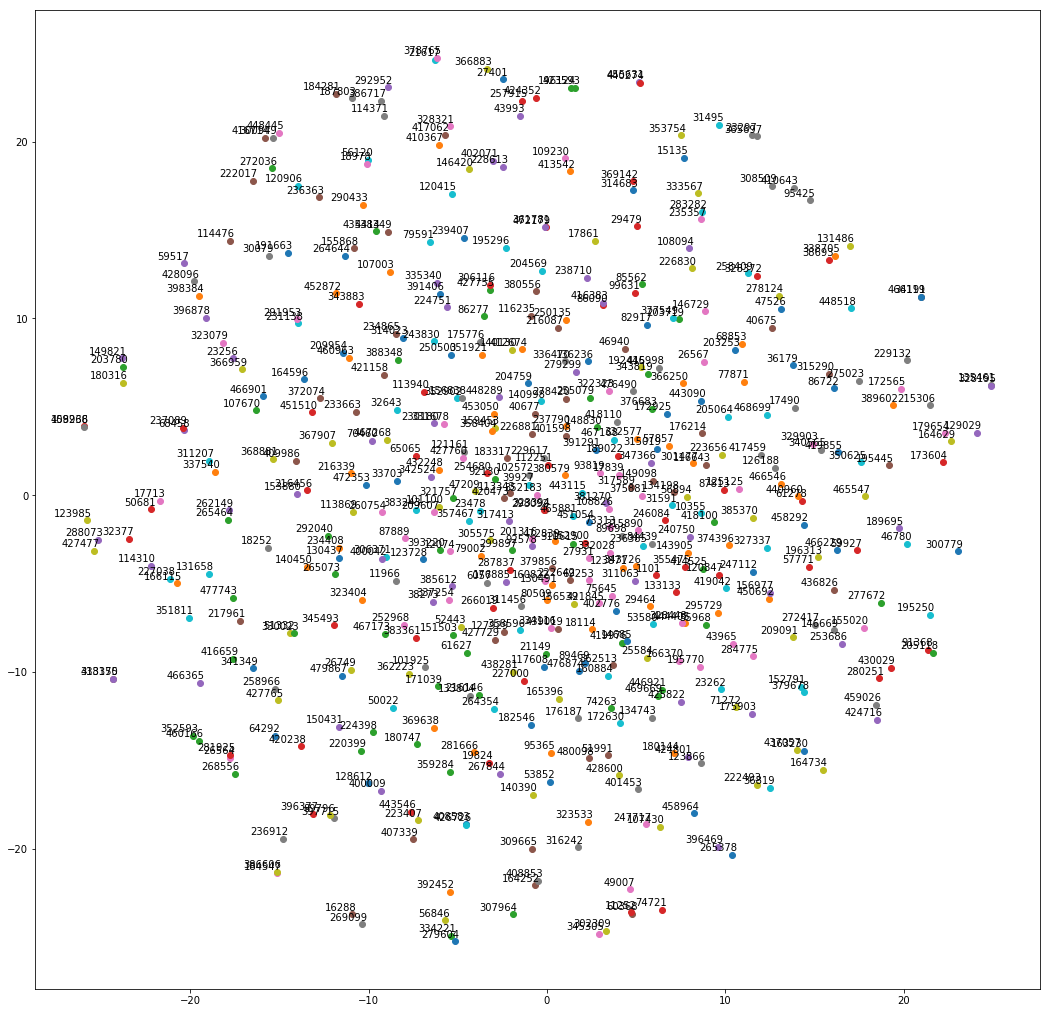

In [ ]:
import numpy as np
import tensorflow as tf
import keras as k
from keras import Sequential
import random
from keras.layers import Embedding
from tensorflow.contrib.tensorboard.plugins import projector
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import h5py
import pickle
import pdb
from progressbar import log_progress

log_dir = '/home/steich/NF_Prize_Data/log'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
x_train = []
y_train = []
with open('../data/user_embedding_5_thresh_train.tsv', 'r') as iFile:
    for line in iFile:
        line = line.replace('\n', '')
        line = line.split('\t')
        x_train.append(eval(line[1]))
        y_train.append(int(line[0]))
        
epochs = 100
batch_size = 32
embedding_size = 64
num_sampled = 64

with open('../data/name_one_hot_dict.pickle', 'rb') as handle:
    name_one_hot = pickle.load(handle)
    
name_count = len(name_one_hot)

def generate_batch(train_features, train_labels, batch_size, steps):
    
    batch_samples = np.zeros((batch_size))
    batch_labels = np.zeros((batch_size, 1))
    index_list = list(range(len(train_labels)))
    random.shuffle(index_list)
    batch_count = 0
    step = 0
    
    while step < steps:
        
        curr_index = index_list[-1]
        for i in train_features[curr_index]:
            
            if batch_count == 32:
                batch_count = 0
                step += 1
                yield (batch_samples, batch_labels)
            
            batch_labels[batch_count][0] = name_one_hot[train_labels[curr_index]]
            batch_samples[batch_count] = name_one_hot[i]
            batch_count += 1
            
        index_list.pop()
        
graph = tf.Graph()
with graph.as_default():
    
    #input data here
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        #valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
    with tf.device('/gpu:0'):
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([name_count, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)
            
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [name_count, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)))
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([name_count]))
            
    
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                inputs=embed,
                labels=train_labels,
                num_sampled=num_sampled,
                num_classes=name_count))
        
    tf.summary.scalar('loss', loss)
    
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
        
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    #valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    #similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    merged = tf.summary.merge_all()
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    
with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter(log_dir, session.graph)
    
    init.run()
    print('Initialized')
    
    steps = 1000
    average_loss = 0
    step = 0
    run_metadata = tf.RunMetadata()
    
    for epoch in range(epochs):
        if epoch > 0:
            print('Epoch: ', epoch, ' - Average Loss: ', average_loss / steps)
            average_loss = 0
        else:
            print('Epoch: ', epoch)
            
        for batch_inputs, batch_labels in log_progress(generate_batch(x_train, y_train, batch_size, steps),
                                                      every=1,
                                                      size=steps,
                                                      name="Batch"):
            
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

            run_metadata = tf.RunMetadata()

            _, summary, loss_val = session.run(
                [optimizer, merged, loss],
                feed_dict=feed_dict,
                run_metadata=run_metadata)
            average_loss += loss_val

            writer.add_summary(summary, step)
            step += 1
        
    writer.add_run_metadata(run_metadata, 'step%d' % step)
    final_embeddings = normalized_embeddings.eval()
    saver.save(session, os.path.join(log_dir, 'metadata.ckpt'))
    
writer.close()

from sklearn.manifold import TSNE
    
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
n = len(final_embeddings)
sample = random.sample(range(n), 500)
low_dim_embs = tsne.fit_transform([final_embeddings[i] for i in sample])
labels = sample
plt.figure(figsize=(18,18))
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x,y)
    plt.annotate(label,
                    xy=(x, y),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
plt.savefig("/home/steich/NF_Prize_Data/data/tsne_user_embeddings_bow_thresh.png")
plt.show()
    
with open('/home/steich/NF_Prize_Data/data/user_emb_bow_thresh_unweighted.tsv', 'w') as f:
    for i, embs in enumerate(final_embeddings):
        emb_str = [str(emb) for emb in embs]
        f.write(str(i) + '\t' + '\t'.join(emb_str) + '\n')

/home/steich/NF_Prize_Data/nf_prize_env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Initialized
Epoch:  0


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  1  - Average Loss:  282.0476734619141


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  2  - Average Loss:  250.52641741943359


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  3  - Average Loss:  228.5533304901123


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  4  - Average Loss:  218.7359927520752


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  5  - Average Loss:  208.52891203308104


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  6  - Average Loss:  202.4528664932251


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  7  - Average Loss:  193.5076616973877


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  8  - Average Loss:  190.57244184112548


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  9  - Average Loss:  184.38606866455078


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  10  - Average Loss:  181.4573975982666


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  11  - Average Loss:  177.36425119018554


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  12  - Average Loss:  173.90751698303222


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  13  - Average Loss:  169.5646791000366


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  14  - Average Loss:  167.85513865661622


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  15  - Average Loss:  163.06347871398927


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  16  - Average Loss:  161.7150713043213


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  17  - Average Loss:  157.47838619995116


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  18  - Average Loss:  155.68766609954835


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  19  - Average Loss:  153.2573872566223


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  20  - Average Loss:  150.769688495636


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  21  - Average Loss:  148.77537171936035


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  22  - Average Loss:  144.74094772720338


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  23  - Average Loss:  145.444472366333


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  24  - Average Loss:  142.2839389038086


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  25  - Average Loss:  139.17042591094972


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  26  - Average Loss:  138.44604962158203


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  27  - Average Loss:  137.61268333435058


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  28  - Average Loss:  136.13179683303832


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  29  - Average Loss:  132.3703830833435


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  30  - Average Loss:  129.54193143463135


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  31  - Average Loss:  128.23740784454347


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  32  - Average Loss:  125.9760052986145


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  33  - Average Loss:  124.68910023880005


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  34  - Average Loss:  124.27971188354492


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  35  - Average Loss:  120.76313982391358


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  36  - Average Loss:  118.94760676574707


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  37  - Average Loss:  115.4667952156067


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  38  - Average Loss:  114.61527981948852


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  39  - Average Loss:  111.69080026626587


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  40  - Average Loss:  110.52368306732178


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  41  - Average Loss:  107.93609763145447


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  42  - Average Loss:  105.88048427772522


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  43  - Average Loss:  103.1642483100891


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  44  - Average Loss:  101.0927216873169


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  45  - Average Loss:  98.10986826896668


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  46  - Average Loss:  96.86414110183716


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  47  - Average Loss:  94.24024624443054


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  48  - Average Loss:  92.95495582008361


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  49  - Average Loss:  90.5484365196228


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  50  - Average Loss:  89.99229949951172


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  51  - Average Loss:  87.58844115829467


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  52  - Average Loss:  85.2100892162323


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  53  - Average Loss:  82.33615483856201


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  54  - Average Loss:  81.45931358718872


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  55  - Average Loss:  78.72986657524109


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  56  - Average Loss:  77.30330863189697


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  57  - Average Loss:  75.63837035369873


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  58  - Average Loss:  72.95794278240204


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  59  - Average Loss:  70.9831981639862


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  60  - Average Loss:  70.67774885368347


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  61  - Average Loss:  68.82813820362091


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  62  - Average Loss:  68.95394424533843


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  63  - Average Loss:  65.51769890499115


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  64  - Average Loss:  64.8048328666687


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  65  - Average Loss:  62.69861666488647


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  66  - Average Loss:  61.6746944360733


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  67  - Average Loss:  60.070141920089725


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  68  - Average Loss:  58.42500888729096


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  69  - Average Loss:  56.477035948753354


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  70  - Average Loss:  56.49311699581146


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  71  - Average Loss:  55.00271317958832


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  72  - Average Loss:  53.00651082277298


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  73  - Average Loss:  52.959346507072446


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  74  - Average Loss:  52.11487867689133


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  75  - Average Loss:  50.09105627250671


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  76  - Average Loss:  49.16446797370911


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  77  - Average Loss:  48.882749133586884


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  78  - Average Loss:  47.7178695936203


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  79  - Average Loss:  46.1270489795208


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  80  - Average Loss:  45.35878061008454


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  81  - Average Loss:  44.51613084602356


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  82  - Average Loss:  43.934827809333804


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  83  - Average Loss:  43.482727190494536


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  84  - Average Loss:  42.06276924133301


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  85  - Average Loss:  40.890683179855344


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  86  - Average Loss:  40.39842712259293


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

Epoch:  87  - Average Loss:  40.20612968921662


VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))